# Compute Test error

compute Error per scenario and for all replicates together and over time steps for Test set

The mean error should be:


$$MSE = \frac{1}{n_{time}}\left(\sum_{t} \frac{1}{n_{scen}}\sum_{i}\left(\left(\frac{1}{100}\sum_{j}^{100} \hat{\Theta}_i^j\right) - \Theta_i\right)^2\right)$$

- $j$: replicates
- $i$: scenarios
- $t$: time steps

# import

In [2]:
import sys
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling1D
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import scipy.stats as ss

sys.path.append("demography")
import utils

# Definitions

In [2]:
batch_size = 200
epochs = 10
nindiv = 50
numParams = 21
NUM_GPU = 1

In [3]:
def resort_min_diff(amat):
    # assumes your snp matrix is indv. on rows, snps on cols
    mb = NearestNeighbors(len(amat), metric='manhattan', n_jobs=1).fit(amat)
    v = mb.kneighbors(amat)
    smallest = np.argmin(v[0].sum(axis=1))
    return amat[v[1][smallest]]


In [4]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, indices, scen_params_preprocessed, batchSize,
                 SNP_maxx, sort_rows, encodingg, max_distance):
        self.indices = indices
        self.scenario_params_preprocessed = scen_params_preprocessed
        self.batch_size = batchSize
        self.SNP_max = SNP_maxx
        self.sortRows = sort_rows # True/False
        self.encoding = encodingg # "255/1"
        self.maxDistance = max_distance # max distance btw snps

    def __len__(self): # number of batches
        return int(np.ceil(len(self.indices) / float(self.batch_size)))

    def __getitem__(self, idx): # should return entire batch
        batch_snp = []
        batch_pos = []
        batch_demo = []
        batch_scenario_idx = []
        for index in range(idx, idx+batch_size):
            scenario_idx, npz_path = self.indices[index]
            scenario_data = scenario_params_preprocessed.loc[scenario_idx].copy()

            with np.load(npz_path) as data_npz:
                pos = (((data_npz['POS'] / self.maxDistance) / 2e6) * 2) - 1 # positions between -1 and 1
                snp = data_npz["SNP"]
            snp = resort_min_diff(snp) # sort matrix
            if self.encoding == "1":
                snp = snp.astype("float")*2 - 1 # between -1,1
            else:
                snp = (snp*255).astype('int8') # 0->0 ; 255 -> -1

            if self.SNP_max == 400: # truncate up to SNP_max

                batch_pos.append(pos[:self.SNP_max])
                new_snp = snp[:, :self.SNP_max]
                batch_snp.append(new_snp.T)

            else: # need to pad up to 17839 (max number of snp in Theophile's simulations)
                # snp_2_keep = np.sort(np.random.choice(snp.shape[1],
                #                                int(snp.shape[1]/10), # take about 10% of the initial snps
                #                                replace=False))
                # subsample as in flagel's code:
                snp_2_keep = np.arange(snp.shape[1])[::10]
                snp = snp[:, snp_2_keep]
                p_tmp = pos.cumsum()[snp_2_keep] # subsample in the absolute distance space
                pos = np.r_[p_tmp[0], np.diff(p_tmp)] # recompute the diff and concat (r_) with first value

                new_pos = np.zeros(SNP_max)
                new_pos[:pos.shape[0]] = pos
                new_snp = np.zeros((snp.shape[0], SNP_max))
                new_snp[:snp.shape[0], :snp.shape[1]] = snp
                batch_pos.append(new_pos)
                batch_snp.append(new_snp.T)

            batch_demo.append(scenario_data.filter(regex="pop.*size").values) # 21 demo parameters
            batch_scenario_idx.append(scenario_idx)
            
        return np.array(batch_scenario_idx), (np.array(batch_snp), np.array(batch_pos)), np.array(batch_demo)


In [21]:
def build_model(inputShape, convFunc, useDropout):
    #inputShape = (SNP_max, nindiv)
    poolFunc = AveragePooling1D
    b1 = Input(shape=inputShape)
    convSize=2 
    poolSize=2 

    conv11 = convFunc(128, kernel_size=convSize, activation='relu')(b1)
    pool11 = poolFunc(pool_size=poolSize)(conv11)
    if useDropout:
        pool11 = Dropout(0.25)(pool11)
    conv12 = convFunc(128, kernel_size=2, activation='relu')(pool11)
    pool12 = poolFunc(pool_size=poolSize)(conv12)
    if useDropout:
        pool12 = Dropout(0.25)(pool12)
    conv13 = convFunc(128, kernel_size=2, activation='relu')(pool12)
    pool13 = poolFunc(pool_size=poolSize)(conv13)
    if useDropout:
        pool13 = Dropout(0.25)(pool13)
    conv14 = convFunc(128, kernel_size=2, activation='relu')(pool13)
    pool14 = poolFunc(pool_size=poolSize)(conv14)
    if useDropout:
        pool14 = Dropout(0.25)(pool14)
    flat11 = Flatten()(pool14)

    b2 = Input(shape=(SNP_max,))
    dense21 = Dense(32, activation='relu')(b2)
    if useDropout:
        dense21 = Dropout(0.25)(dense21)

    merged = concatenate([flat11, dense21])
    denseMerged = Dense(256, activation='relu',
                        kernel_initializer='normal')(merged)
    if useDropout:
        denseMerged = Dropout(0.25)(denseMerged)
    denseOutput = Dense(numParams)(denseMerged)
    model = Model(inputs=[b1, b2], outputs=denseOutput)
    #print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [30]:
len(my_validation_batch_generator)

383

In [49]:
def run_test(test_batch_generator, model, run_id):
    all_df_pred = pd.DataFrame()
    all_df_exp = pd.DataFrame()
    
    for j,i in enumerate(range(0, len(test_batch_generator.indices), batch_size)):
        batch = test_batch_generator[i]
        pred = model.predict(batch[1])#, verbose=True)
        df_pred = pd.DataFrame(pred)
        df_exp = pd.DataFrame(batch[2].astype(float))
        df_pred["scenario_idx"] = batch[0]
        df_exp["scenario_idx"] = batch[0]
        all_df_pred = pd.concat([all_df_pred, df_pred])
        all_df_exp = pd.concat([all_df_exp, df_exp])
        if j % 50 == 0:
            print("batch {} done".format(j))  
            print(np.unique(batch[0], return_counts=True))
    all_df_pred.set_index("scenario_idx").to_csv("all_pred_{}.csv".format(run_id), sep="\t")
    all_df_exp.set_index("scenario_idx").to_csv("all_exp_TEST_{}.csv".format(run_id), sep="\t")
    return all_df_pred, all_df_exp

# Create loader

In [6]:
preprocessed_scenario_params_path="/home/tau/thsanche/data_test/cattle_run_0_preprocessed_param.csv"

In [7]:
scenario_params_preprocessed = pd.read_csv(preprocessed_scenario_params_path, index_col=0)

In [12]:
num_scenario = len(scenario_params_preprocessed)
simu_data_path = "/home/tau/thsanche/data_test/"
print("Building indices...")
test_indices = []
for scenario in scenario_params_preprocessed.itertuples(): # here they are all test scenarios
    for k in range(scenario.num_replicates):
        
        data = (scenario.Index,
                os.path.join(simu_data_path,
                            utils.generate_filename((scenario.Index, k),
                                                   "cattle",
                                                   20000, # not used
                                                   scenario.num_replicates,
                                                   return_abs_path=True,
                                                   format_scen="",
                                                   format_rep="",
                                                   )
                            )
               )
        test_indices.append(data)
print("... Done")

Building indices...
... Done


In [13]:
len(test_indices)

76600

## Archi 1 : All SNP, encoding=255, conv1D, dropout

In [14]:
SNP_max, nindiv = 1784, 50
convFunc = Conv1D
useDropout = True

In [39]:
my_validation_batch_generator1 = DataGenerator(test_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              SNP_max,
                                              sort_rows=True,
                                              encodingg="255",
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [22]:
model1 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [24]:
model1.load_weights("Model_weigths_SNP1784_conv1d_drop-True_encode-255_shuf")

In [44]:
all_df_pred1, all_df_exp1 = run_test(my_validation_batch_generator,
                                     model1,
                                     "TEST_SNP1784_conv1d_drop-True_encode-255_shuf")

200/200 [==============================] - 6s 28ms/sample
batch 0 done
(array([0, 1]), array([100, 100]))
200/200 [==============================] - 0s 971us/sample
batch 50 done
(array([251, 252]), array([100, 100]))
200/200 [==============================] - 0s 872us/sample
batch 100 done
(array([498, 504]), array([100, 100]))
200/200 [==============================] - 0s 859us/sample


200/200 [==============================] - 0s 699us/sample
batch 150 done
(array([740, 743]), array([100, 100]))
200/200 [==============================] - 0s 862us/sample
batch 200 done
(array([1005, 1007]), array([100, 100]))
200/200 [==============================] - 0s 867us/sample
batch 250 done
(array([1251, 1252]), array([100, 100]))
200/200 [==============================] - 0s 968us/sample


200/200 [==============================] - 0s 986us/sample
batch 300 done
(array([1545, 1547]), array([100, 100]))
200/200 [==============================] - 0s 912us/sample
batch 350 done
(array([1810, 1811]), array([100, 100]))
200/200 [==============================] - 0s 752us/sample


In [3]:
all_df_pred1 = pd.read_csv("./all_pred_TEST_SNP1784_conv1d_drop-True_encode-255_shuf.csv", sep="\t")
all_df_exp1 = pd.read_csv("./all_exp_TEST_TEST_SNP1784_conv1d_drop-True_encode-255_shuf.csv", sep="\t")

In [4]:
MS1 = ((all_df_pred1.groupby("scenario_idx").mean() - all_df_exp1.groupby("scenario_idx").mean())**2)

In [5]:
MSE1 = MS1.T.apply(["mean", "std", "sem"]).T

In [6]:
MSE1.to_csv("MSE_TEST_SNP1784_conv1d_drop-True_encode-255_shuf.csv")

In [7]:
MSE1.mean()

mean    0.457037
std     0.570344
sem     0.124459
dtype: float64

## Archi 2: 400 SNP, encoding=255, conv1D, dropout

In [55]:
SNP_max, nindiv = 400, 50
convFunc = Conv1D
useDropout = True
encoding = "255"

In [56]:
my_validation_batch_generator2 = DataGenerator(test_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              400,
                                              sort_rows=True,
                                              encodingg=encoding,
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [57]:
model2 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=True)

In [58]:
model2.load_weights("Model_weigths_SNP400_conv1d_drop-True_encode-255_shuf")

In [59]:
all_df_pred2, all_df_exp2 = run_test(my_validation_batch_generator2,
                                     model2,
                                     "TEST_SNP400_conv1d_drop-True_encode-255_shuf")

batch 0 done
(array([0, 1]), array([100, 100]))
batch 50 done
(array([251, 252]), array([100, 100]))
batch 100 done
(array([498, 504]), array([100, 100]))
batch 150 done
(array([740, 743]), array([100, 100]))
batch 200 done
(array([1005, 1007]), array([100, 100]))
batch 250 done
(array([1251, 1252]), array([100, 100]))
batch 300 done
(array([1545, 1547]), array([100, 100]))
batch 350 done
(array([1810, 1811]), array([100, 100]))


In [8]:
all_df_pred2 = pd.read_csv("./all_pred_TEST_SNP400_conv1d_drop-True_encode-255_shuf.csv", sep="\t")
all_df_exp2 = pd.read_csv("./all_exp_TEST_TEST_SNP400_conv1d_drop-True_encode-255_shuf.csv", sep="\t")

In [9]:
MS2 = ((all_df_pred2.groupby("scenario_idx").mean() - all_df_exp2.groupby("scenario_idx").mean())**2)

In [10]:
MSE2 = MS2.T.apply(["mean", "std", "sem"]).T

In [11]:
MSE2.to_csv("MSE_TEST_SNP400_conv1d_drop-True_encode-255_shuf.csv")

In [12]:
MSE2.mean()

mean    0.563088
std     0.657144
sem     0.143400
dtype: float64

## Archi 3: All SNP, encoding=1, conv1D, No dropout

In [64]:
SNP_max, nindiv = 1784, 50
convFunc = Conv1D
useDropout = False
encoding = "1"

In [65]:
my_validation_batch_generator3 = DataGenerator(test_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              SNP_max,
                                              sort_rows=True,
                                              encodingg=encoding,
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [66]:
model3 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=useDropout)

In [67]:
model3.load_weights("Model_weigths_SNP1784_conv1d_drop-False_encode-1_shuf")

In [68]:
all_df_pred3, all_df_exp3 = run_test(my_validation_batch_generator3,
                                     model3,
                                     "TEST_SNP1784_conv1d_drop-False_encode-1_shuf")

batch 0 done
(array([0, 1]), array([100, 100]))
batch 50 done
(array([251, 252]), array([100, 100]))
batch 100 done
(array([498, 504]), array([100, 100]))
batch 150 done
(array([740, 743]), array([100, 100]))
batch 200 done
(array([1005, 1007]), array([100, 100]))
batch 250 done
(array([1251, 1252]), array([100, 100]))
batch 300 done
(array([1545, 1547]), array([100, 100]))
batch 350 done
(array([1810, 1811]), array([100, 100]))


In [13]:
all_df_pred3 = pd.read_csv("./all_pred_TEST_SNP1784_conv1d_drop-False_encode-1_shuf.csv", sep="\t")
all_df_exp3 = pd.read_csv("./all_exp_TEST_TEST_SNP1784_conv1d_drop-False_encode-1_shuf.csv", sep="\t")

In [14]:
MS3 = ((all_df_pred3.groupby("scenario_idx").mean() - all_df_exp3.groupby("scenario_idx").mean())**2)

In [15]:
MSE3 = MS3.T.apply(["mean", "std", "sem"]).T

In [16]:
MSE3.to_csv("MSE_TEST_SNP1784_conv1d_drop-False_encode-1_shuf.csv")

In [17]:
MSE3.mean()

mean    0.500459
std     0.630140
sem     0.137508
dtype: float64

## Archi 4: 400 SNP, encoding=1, conv1D, No dropout

In [73]:
SNP_max, nindiv = 400, 50
convFunc = Conv1D
useDropout = False
encoding = "1"

In [74]:
my_validation_batch_generator4 = DataGenerator(test_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              400,
                                              sort_rows=True,
                                              encodingg=encoding,
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [75]:
model4 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=useDropout)

In [76]:
model4.load_weights("Model_weigths_SNP400_conv1d_drop-False_encode-1_shuf")

In [77]:
all_df_pred4, all_df_exp4 = run_test(my_validation_batch_generator4,
                                     model4,
                                     "TEST_SNP400_conv1d_drop-False_encode-1_shuf")

batch 0 done
(array([0, 1]), array([100, 100]))
batch 50 done
(array([251, 252]), array([100, 100]))
batch 100 done
(array([498, 504]), array([100, 100]))
batch 150 done
(array([740, 743]), array([100, 100]))
batch 200 done
(array([1005, 1007]), array([100, 100]))
batch 250 done
(array([1251, 1252]), array([100, 100]))
batch 300 done
(array([1545, 1547]), array([100, 100]))
batch 350 done
(array([1810, 1811]), array([100, 100]))


In [18]:
all_df_pred4 = pd.read_csv("./all_pred_TEST_SNP400_conv1d_drop-False_encode-1_shuf.csv", sep="\t")
all_df_exp4 = pd.read_csv("./all_exp_TEST_TEST_SNP400_conv1d_drop-False_encode-1_shuf.csv", sep="\t")

In [19]:
MS4 = ((all_df_pred4.groupby("scenario_idx").mean() - all_df_exp4.groupby("scenario_idx").mean())**2)

In [20]:
MSE4 = MS4.T.apply(["mean", "std", "sem"]).T

In [21]:
MSE4.to_csv("MSE_TEST_SNP400_conv1d_drop-False_encode-1_shuf.csv")

In [22]:
MSE4.mean()

mean    0.630544
std     0.723080
sem     0.157789
dtype: float64

# Summary

In [90]:
MSE1.mean().to_frame(name="A")

A
mean  0.457037
std   0.570344
sem   0.124459

In [31]:
res = pd.concat([MSE1.mean().to_frame(name="TEST_SNP1784_conv1d_drop-True_encode-255_shuf"),
                 MSE2.mean().to_frame(name="TEST_SNP400_conv1d_drop-True_encode-255_shuf"),
                 MSE3.mean().to_frame(name="TEST_SNP1784_conv1d_drop-False_encode-1_shuf"),
                 MSE4.mean().to_frame(name="TEST_SNP400_conv1d_drop-False_encode-1_shuf"),
                ], axis=1)

In [32]:
res.T

mean       std       sem
TEST_SNP1784_conv1d_drop-True_encode-255_shuf  0.457037  0.570344  0.124459
TEST_SNP400_conv1d_drop-True_encode-255_shuf   0.563088  0.657144  0.143400
TEST_SNP1784_conv1d_drop-False_encode-1_shuf   0.500459  0.630140  0.137508
TEST_SNP400_conv1d_drop-False_encode-1_shuf    0.630544  0.723080  0.157789

Text(0, 0.5, 'MSE')

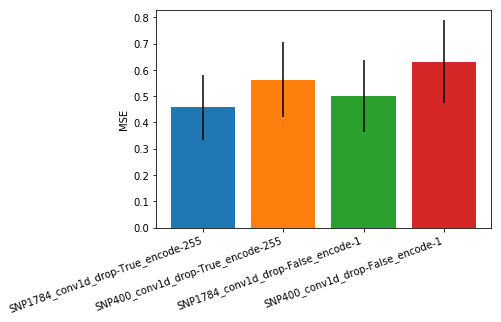

In [33]:
for i,j in enumerate(res.T.itertuples()):
    plt.bar(i, j.mean, yerr=j.sem)
plt.xticks(range(4), [k[5:-5] for k in res.columns], rotation=20, ha="right")
plt.ylabel("MSE")

# Anciens calcules

$$MSE = \frac{1}{n_{time}}\left(\sum_{t} \frac{1}{n_{scen}}\sum_{i}\left(\frac{1}{100}\sum_{j}^{100} \left(\hat{\Theta}_i^j - \Theta_i\right)^2\right)\right)$$

- $j$: replicates
- $i$: scenarios
- $t$: time steps

In [26]:
all_df_pred1.set_index("scenario_idx", inplace=True)
all_df_exp1.set_index("scenario_idx", inplace=True)
all_df_pred2.set_index("scenario_idx", inplace=True)
all_df_exp2.set_index("scenario_idx", inplace=True)
all_df_pred3.set_index("scenario_idx", inplace=True)
all_df_exp3.set_index("scenario_idx", inplace=True)
all_df_pred4.set_index("scenario_idx", inplace=True)
all_df_exp4.set_index("scenario_idx", inplace=True)

MSo1 = ((all_df_pred1 - all_df_exp1)**2).groupby(level=0).mean()
MSoE1 = MSo1.T.apply(["mean", "std", "sem"]).T

MSo2 = ((all_df_pred2 - all_df_exp2)**2).groupby(level=0).mean()
MSoE2 = MSo2.T.apply(["mean", "std", "sem"]).T

MSo3 = ((all_df_pred3 - all_df_exp3)**2).groupby(level=0).mean()
MSoE3 = MSo3.T.apply(["mean", "std", "sem"]).T

MSo4 = ((all_df_pred4 - all_df_exp4)**2).groupby(level=0).mean()
MSoE4 = MSo4.T.apply(["mean", "std", "sem"]).T


In [29]:

res2 = pd.concat([MSoE1.mean().to_frame(name="TEST_SNP1784_conv1d_drop-True_encode-255_shuf"),
                 MSoE2.mean().to_frame(name="TEST_SNP400_conv1d_drop-True_encode-255_shuf"),
                 MSoE3.mean().to_frame(name="TEST_SNP1784_conv1d_drop-False_encode-1_shuf"),
                 MSoE4.mean().to_frame(name="TEST_SNP400_conv1d_drop-False_encode-1_shuf"),
                ], axis=1)

In [30]:
res2.T

mean       std       sem
TEST_SNP1784_conv1d_drop-True_encode-255_shuf  0.542534  0.587267  0.128152
TEST_SNP400_conv1d_drop-True_encode-255_shuf   0.689940  0.668488  0.145876
TEST_SNP1784_conv1d_drop-False_encode-1_shuf   0.751017  0.654092  0.142735
TEST_SNP400_conv1d_drop-False_encode-1_shuf    1.024113  0.749028  0.163451

Text(0.5, 1.0, 'Test error')

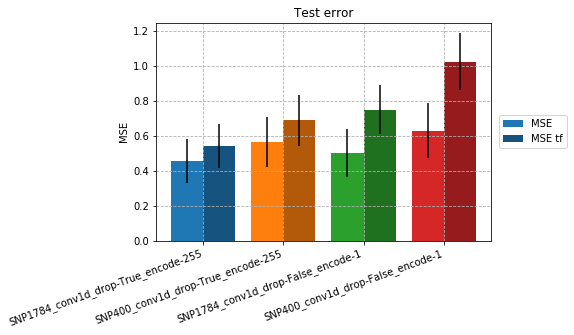

In [34]:
for i,(j,j2) in enumerate(zip(res.T.itertuples(), res2.T.itertuples())):
    b=plt.bar(i-0.2, j.mean, yerr=j.sem, width=0.4, label="MSE")
    plt.bar(i+0.2, j2.mean, yerr=j2.sem, width=0.4,
            color=np.array(b.patches[0].get_facecolor())*np.array([0.7, 0.7, 0.7, 1]),
            #hatch="///",
           label="MSE tf")
plt.xticks(range(4), [k[5:-5] for k in res.columns], rotation=20, ha="right")
plt.ylabel("MSE")
#plt.axhline(1, color="k", linestyle="--", zorder=-100)
#plt.axhline(0.5, color="k", linestyle="--", zorder=-100)
ax = plt.gca()
ax.grid(True, linestyle="--")
ax.legend(ax.patches[:2], ["MSE", "MSE tf"], loc=6, bbox_to_anchor=(1.01, 0.5))
plt.title("Test error")

In [46]:
pd.concat([res.loc["mean"], res2.loc["mean"]], keys=["mse", "tf"]).unstack()

TEST_SNP1784_conv1d_drop-True_encode-255_shuf  \
mse                                       0.457037   
tf                                        0.542534   

     TEST_SNP400_conv1d_drop-True_encode-255_shuf  \
mse                                      0.563088   
tf                                       0.689940   

     TEST_SNP1784_conv1d_drop-False_encode-1_shuf  \
mse                                      0.500459   
tf                                       0.751017   

     TEST_SNP400_conv1d_drop-False_encode-1_shuf  
mse                                     0.630544  
tf                                      1.024113